In [1]:
from PIL import Image
from six.moves import cPickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.training import moving_averages
import tensorflow as tf
import glob
import os

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load dataset for semantic segmentation

In [2]:
#Location of the file
camvidpath = 'data/CamVid/'

#Train dataset
train_path = camvidpath + 'train/'
trainannot_path = camvidpath + 'trainannot/'
train_img_list = glob.glob(train_path + '/*.png')
train_annot_list = glob.glob(trainannot_path + '/*.png')
print('%d train images' % len(train_img_list))
print('%d train annotations' % len(train_annot_list))

#Test dataset
test_path = camvidpath + 'test/'
testannot_path = camvidpath + 'testannot/'
test_img_list = glob.glob(test_path + '/*.png')
test_annot_list = glob.glob(testannot_path + '/*.png')
print('%d test images' % len(test_img_list))
print('%d test annotations' % len(test_annot_list))

367 train images
367 train annotations
233 test images
233 test annotations


# Get train / test images dataset

In [3]:
#Params
height = 128
width = 128
n_classes = 22

train_data = None
train_label = None
train_label_onehot = None
trainlen = len(train_img_list)

test_data = None
test_label = None
test_label_onehot = None
testlen = len(test_img_list)

#Convert class labels from scalars to one-hot vector function
def LabelToOneHot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_onehot = np.zeros((num_labels, num_classes))
    labels_onehot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_onehot

### Train data process

In [4]:
for (f1, f2, i) in zip(train_img_list, train_annot_list, range(trainlen)):
#     print('[%d/%d], f1: %s, f2: %s' % (i+1, trainlen, f1, f2))
    
    #Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb_img = np.array(img1).reshape(1, height, width, 3)
    
    #Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    
    #Stack images and labels
    if i == 0:
        train_data = rgb_img
        train_label = label
    else:
        train_data = np.concatenate((train_data, rgb_img), axis=0)
        train_label = np.concatenate((train_label, label), axis=0)
n_train = len(train_data)

#Onehot label
train_label_onehot = np.zeros((train_label.shape[0], train_label.shape[1], train_label.shape[2], n_classes))
for row in range(height):
    for col in range(width):
        single = train_label[:, row, col, 0]
        onehot = LabelToOneHot(single, n_classes) # (367,) -> (367, 22)
        train_label_onehot[:, row, col, :] == onehot
    
print('Train data process done!!')

Train data process done!!


### Test data process

In [5]:
for (f1, f2, i) in zip(test_img_list, test_annot_list, range(testlen)):
#     print('[%d/%d], f1: %s, f2: %s' % (i+1, testlen, f1, f2))
    
    #Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb_img = np.array(img1).reshape(1, height, width, 3)
    
    #Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    
    #Stack images and labels
    if i == 0:
        test_data = rgb_img
        test_label = label
    else:
        test_data = np.concatenate((test_data, rgb_img), axis=0)
        test_label = np.concatenate((test_label, label), axis=0)
n_test = len(test_data)

#Onehot label
test_label_onehot = np.zeros((test_label.shape[0], test_label.shape[1], test_label.shape[2], n_classes))
for row in range(height):
    for col in range(width):
        single = test_label[:, row, col, 0]
        onehot = LabelToOneHot(single, n_classes) # (367,) -> (367, 22)
        test_label_onehot[:, row, col, :] == onehot
    
print('Test data process done!!')

Test data process done!!


In [6]:
print ('Shape of train_data is', train_data.shape)
print ('Shape of train_label is', train_label.shape)
print ('Shape of train_label_onehot is', train_label_onehot.shape)
print ('Shape of test_data is', test_data.shape)
print ('Shape of test_label is', test_label.shape)
print ('Shape of test_label_onehot is', test_label_onehot.shape)

Shape of train_data is (367, 128, 128, 3)
Shape of train_label is (367, 128, 128, 1)
Shape of train_label_onehot is (367, 128, 128, 22)
Shape of test_data is (233, 128, 128, 3)
Shape of test_label is (233, 128, 128, 1)
Shape of test_label_onehot is (233, 128, 128, 22)


# Define Networks params

In [7]:
#Placeholder
x = tf.placeholder(dtype=tf.float32, shape=[None, height, width, 3])
y = tf.placeholder(dtype=tf.float32, shape=[None, height, width, n_classes])
keep_prob = tf.placeholder(dtype=tf.float32)

#Kernels
k_size = 5
f_size = 64
init_stddev = 0.01
init_fun = tf.random_normal_initializer(mean=0.0, stddev=init_stddev)

#Weights & Biases
weights = {
    'ce1': tf.get_variable(name='ce1', shape=[k_size, k_size, 3, f_size], initializer=init_fun),
    'ce2': tf.get_variable(name='ce2', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'ce3': tf.get_variable(name='ce3', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'ce4': tf.get_variable(name='ce4', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'cd4': tf.get_variable(name='cd4', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'cd3': tf.get_variable(name='cd3', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'cd2': tf.get_variable(name='cd2', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'cd1': tf.get_variable(name='cd1', shape=[k_size, k_size, f_size, f_size], initializer=init_fun),
    'dense_inner_prod': tf.get_variable(name='dense_inner_prod', shape=[1, 1, f_size, n_classes], initializer=init_fun) # 1x1 conv
}

biases = {
    'be1': tf.get_variable(name='be1', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'be2': tf.get_variable(name='be2', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'be3': tf.get_variable(name='be3', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'be4': tf.get_variable(name='be4', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'bd4': tf.get_variable(name='bd4', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'bd3': tf.get_variable(name='bd3', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'bd2': tf.get_variable(name='bd2', shape=[f_size], initializer=tf.constant_initializer(value=0.0)),
    'bd1': tf.get_variable(name='bd1', shape=[f_size], initializer=tf.constant_initializer(value=0.0))
}

# DeconvNet model

In [8]:
# input = [m, h, w, c]
def Unpooling(inputorg, size, mask=None):
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    k = np.float32(np.array([1.0, 1.0]).reshape([1, -1]))
    
    # m, c, h, w order
    input = tf.transpose(inputorg, perm=[0, 3, 1, 2])
    x = tf.reshape(input, shape=[-1, 1])
    output = tf.matmul(x, k)
    output = tf.reshape(output, shape=[-1, c, h, w*2])
    
    # m, h, c, w
    xx = tf.transpose(output, perm=[0, 1, 3, 2])
    xx = tf.reshape(xx, shape=[-1, 1])
    output = tf.matmul(xx, k)
    
    # m, c, w, h
    output = tf.reshape(output, shape=[-1, c, w*2, h*2])
    output = tf.transpose(output, perm=[0, 3, 2, 1])
    outshape = tf.stack([m, h*2, w*2, c])
    
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output

In [9]:
# DeconvNet model
def model(x, weights, biases, keep_prob):
    use_bias = 1
    
    #Encoder 128*128
    encoder1 = tf.nn.conv2d(x, weights['ce1'], strides=[1,1,1,1], padding='SAME')
    if use_bias:
        encoder1 = tf.nn.bias_add(encoder1, biases['be1'])
    mean, var = tf.nn.moments(x=encoder1, axes=[0, 1, 2])
    encoder1 = tf.nn.batch_normalization(x=encoder1, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    encoder1 = tf.nn.relu(encoder1)
    encoder1 = tf.nn.max_pool(encoder1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    encoder1 = tf.nn.dropout(x=encoder1, keep_prob=keep_prob)
    
    #Encoder 64*64
    encoder2 = tf.nn.conv2d(encoder1, weights['ce2'], strides=[1,1,1,1], padding='SAME')
    if use_bias:
        encoder2 = tf.nn.bias_add(encoder2, biases['be2'])
    mean, var = tf.nn.moments(x=encoder2, axes=[0, 1, 2])
    encoder2 = tf.nn.batch_normalization(x=encoder2, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    encoder2 = tf.nn.relu(encoder2)
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    encoder2 = tf.nn.dropout(x=encoder2, keep_prob=keep_prob)
    
    #Encoder 32*32
    encoder3 = tf.nn.conv2d(encoder2, weights['ce3'], strides=[1,1,1,1], padding='SAME')
    if use_bias:
        encoder3 = tf.nn.bias_add(encoder3, biases['be3'])
    mean, var = tf.nn.moments(x=encoder3, axes=[0, 1, 2])
    encoder3 = tf.nn.batch_normalization(x=encoder3, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    encoder3 = tf.nn.relu(encoder3)
    encoder3 = tf.nn.max_pool(encoder3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    encoder3 = tf.nn.dropout(x=encoder3, keep_prob=keep_prob)
    
    #Encoder 16*16
    encoder4 = tf.nn.conv2d(encoder3, weights['ce4'], strides=[1,1,1,1], padding='SAME')
    if use_bias:
        encoder4 = tf.nn.bias_add(encoder4, biases['be4'])
    mean, var = tf.nn.moments(x=encoder4, axes=[0, 1, 2])
    encoder4 = tf.nn.batch_normalization(x=encoder4, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    encoder4 = tf.nn.relu(encoder4)
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    encoder4 = tf.nn.dropout(x=encoder4, keep_prob=keep_prob)
    
    
    
    #8*8
    #Decoder 8*8 (128/16=8) fsize = 64
    decoder4 = Unpooling(encoder4, [tf.shape(x)[0], int(height/16), int(width/16), f_size])
    decoder4 = tf.nn.conv2d_transpose(value=decoder4, 
                                      filter=weights['cd4'], 
                                      output_shape=tf.stack([tf.shape(x)[0], k_size, k_size, f_size]), 
                                      strides=[1,1,1,1], 
                                      padding='SAME')
    if use_bias:
        decoder4 = tf.nn.bias_add(decoder4, biases['bd4'])
    mean, var = tf.nn.moments(x=decoder4, axes=[0, 1, 2])
    decoder4 = tf.nn.batch_normalization(x=decoder4, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    decoder4 = tf.nn.relu(decoder4)
    decoder4 = tf.nn.dropout(x=decoder4, keep_prob=keep_prob)
    
    #16*16
    decoder3 = Unpooling(encoder3, [tf.shape(x)[0], int(height/8), int(width/8), f_size])
    decoder3 = tf.nn.conv2d(decoder3, 
                            filter=weights['cd3'],  
                            strides=[1,1,1,1], 
                            padding='SAME')
    if use_bias:
        decoder3 = tf.nn.bias_add(decoder3, biases['bd3'])
    mean, var = tf.nn.moments(x=decoder3, axes=[0, 1, 2])
    decoder3 = tf.nn.batch_normalization(x=decoder3, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    decoder3 = tf.nn.relu(decoder3)
    decoder3 = tf.nn.dropout(x=decoder3, keep_prob=keep_prob)
    
    #32*32
    decoder2 = Unpooling(encoder2, [tf.shape(x)[0], int(height/4), int(width/4), f_size])
    decoder2 = tf.nn.conv2d(decoder2, 
                            filter=weights['cd2'],  
                            strides=[1,1,1,1], 
                            padding='SAME')
    if use_bias:
        decoder2 = tf.nn.bias_add(decoder2, biases['bd2'])
    mean, var = tf.nn.moments(x=decoder2, axes=[0, 1, 2])
    decoder2 = tf.nn.batch_normalization(x=decoder2, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    decoder2 = tf.nn.relu(decoder2)
    decoder2 = tf.nn.dropout(x=decoder2, keep_prob=keep_prob)
    
    #64*64
    decoder1 = Unpooling(encoder1, [tf.shape(x)[0], int(height/2), int(width/2), f_size])
    decoder1 = tf.nn.conv2d(decoder1, 
                            filter=weights['cd1'],  
                            strides=[1,1,1,1], 
                            padding='SAME')
    if use_bias:
        decoder1 = tf.nn.bias_add(decoder1, biases['bd1'])
    mean, var = tf.nn.moments(x=decoder1, axes=[0, 1, 2])
    decoder1 = tf.nn.batch_normalization(x=decoder1, mean=mean, variance=var, offset=0, scale=1, variance_epsilon=0.0001)
    decoder1 = tf.nn.relu(decoder1)
    decoder1 = tf.nn.dropout(x=decoder1, keep_prob=keep_prob)
    
    
    #128*128
    output = tf.nn.conv2d(decoder1, filter=weights['dense_inner_prod'], strides=[1,1,1,1], padding='SAME')
    return output

# Define other functions

In [10]:
y_pred = model(x, weights, biases, keep_prob)
lin_pred = tf.reshape(y_pred, shape=[-1, n_classes])
lin_y = tf.reshape(y, shape=[-1, n_classes])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=lin_pred, labels=lin_y))

#Class label
pred_max = tf.argmax(y_pred, 3)
y_max = tf.argmax(y, 3)

#Accuracy
correct_pred = tf.equal(tf.argmax(y, 3), tf.argmax(y_pred, 3))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

#Params
batch_size = 128
epochs = 50      #should be more than 1000 

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# Training & Optimization phase

Checkpoint:  nets/semseg_basic\progress-0
Restoring from checkpoint nets/semseg_basic\progress-0
INFO:tensorflow:Restoring parameters from nets/semseg_basic\progress-0
[00/50] Train Loss: 0.0000, Train Accuracy: 0.2677, Test Loss: 0.0000, Test Accuracy: 0.2766
[01/50] Train Loss: 0.0000, Train Accuracy: 0.2912, Test Loss: 0.0000, Test Accuracy: 0.2804
[02/50] Train Loss: 0.0000, Train Accuracy: 0.2640, Test Loss: 0.0000, Test Accuracy: 0.2844
[03/50] Train Loss: 0.0000, Train Accuracy: 0.2762, Test Loss: 0.0000, Test Accuracy: 0.2913
[04/50] Train Loss: 0.0000, Train Accuracy: 0.2912, Test Loss: 0.0000, Test Accuracy: 0.2966
[05/50] Train Loss: 0.0000, Train Accuracy: 0.3022, Test Loss: 0.0000, Test Accuracy: 0.3069
[06/50] Train Loss: 0.0000, Train Accuracy: 0.3161, Test Loss: 0.0000, Test Accuracy: 0.3191
[07/50] Train Loss: 0.0000, Train Accuracy: 0.3132, Test Loss: 0.0000, Test Accuracy: 0.3121
[08/50] Train Loss: 0.0000, Train Accuracy: 0.2982, Test Loss: 0.0000, Test Accuracy: 0.

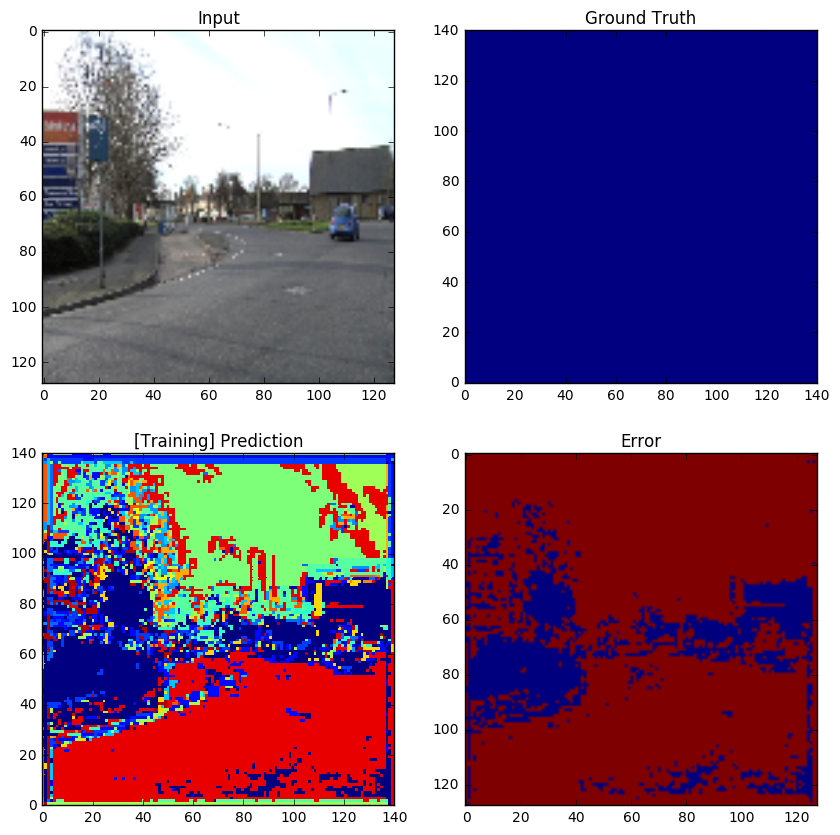

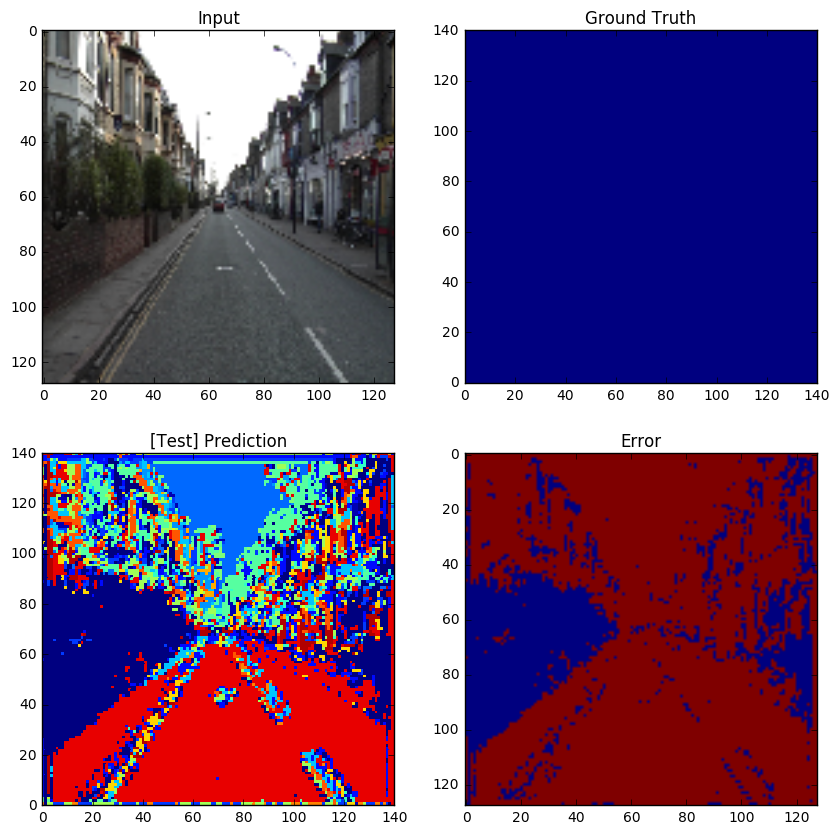

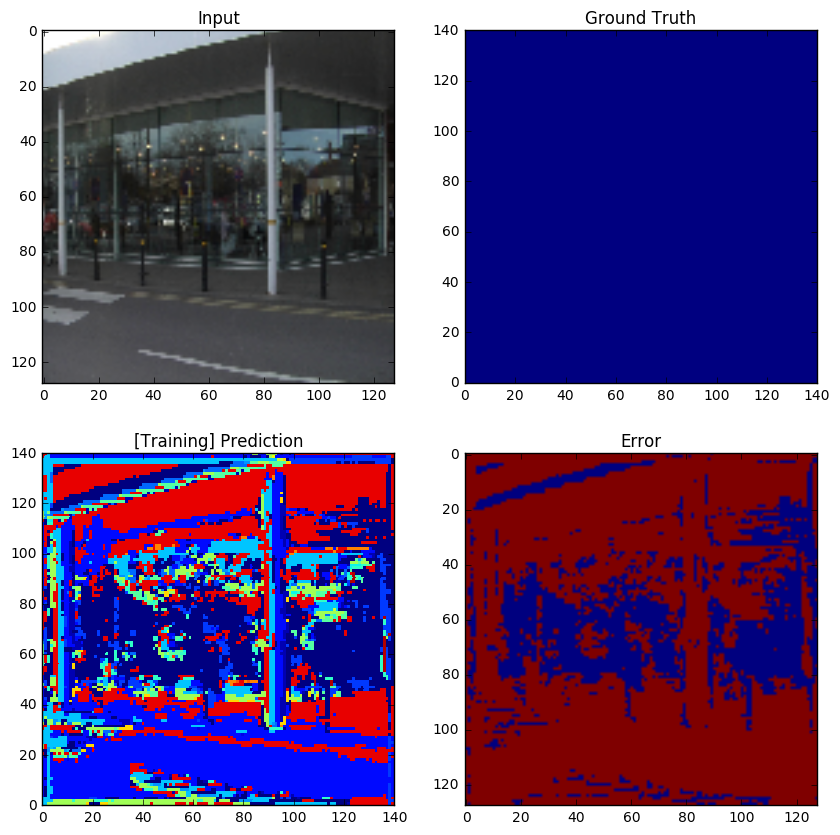

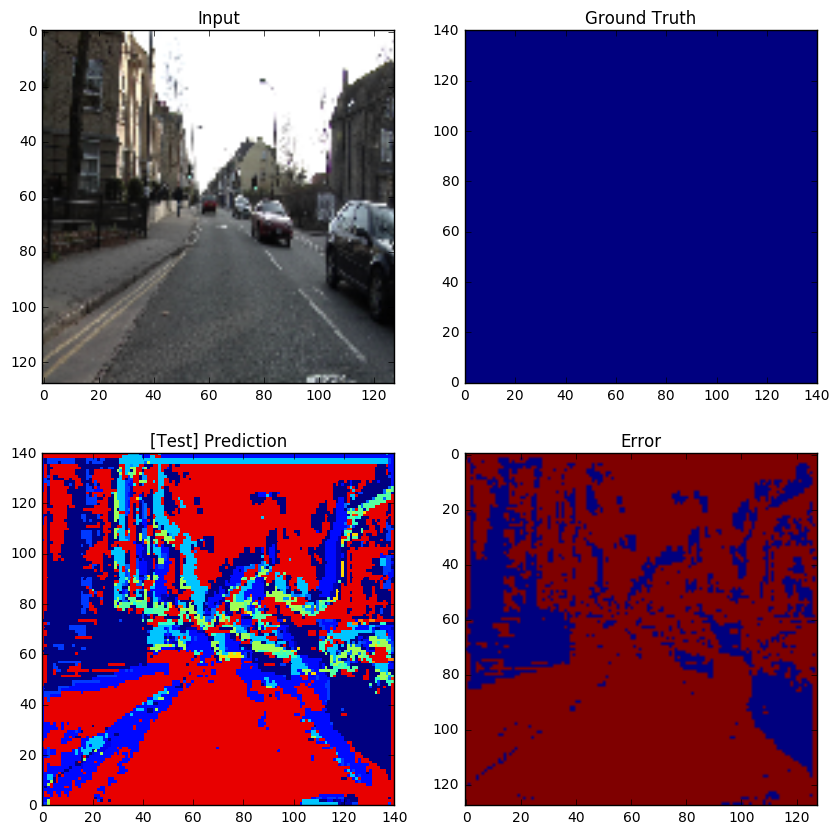

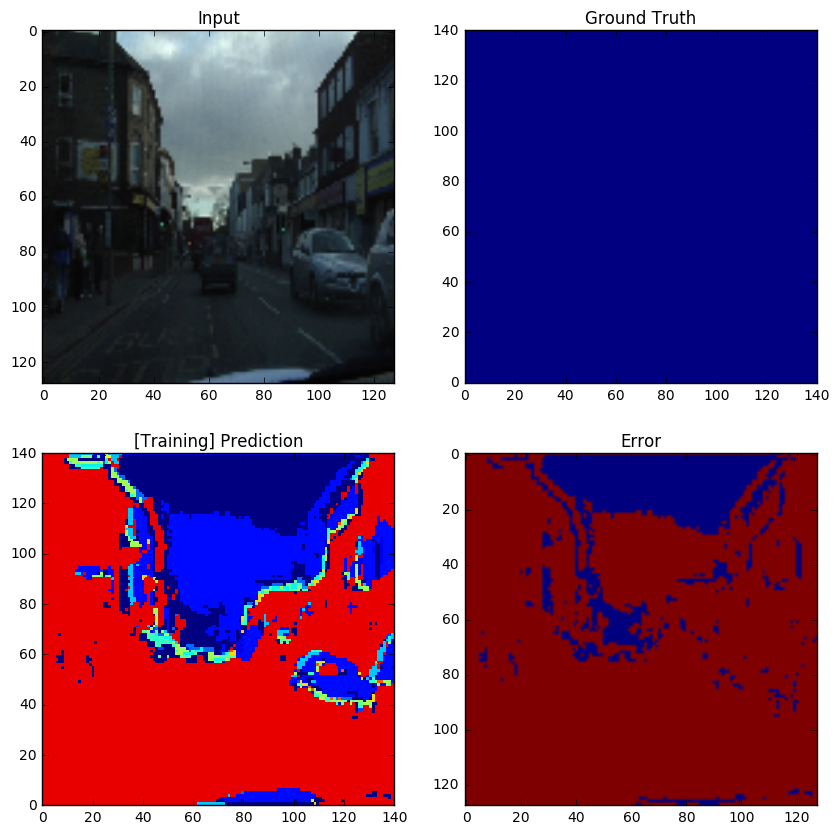

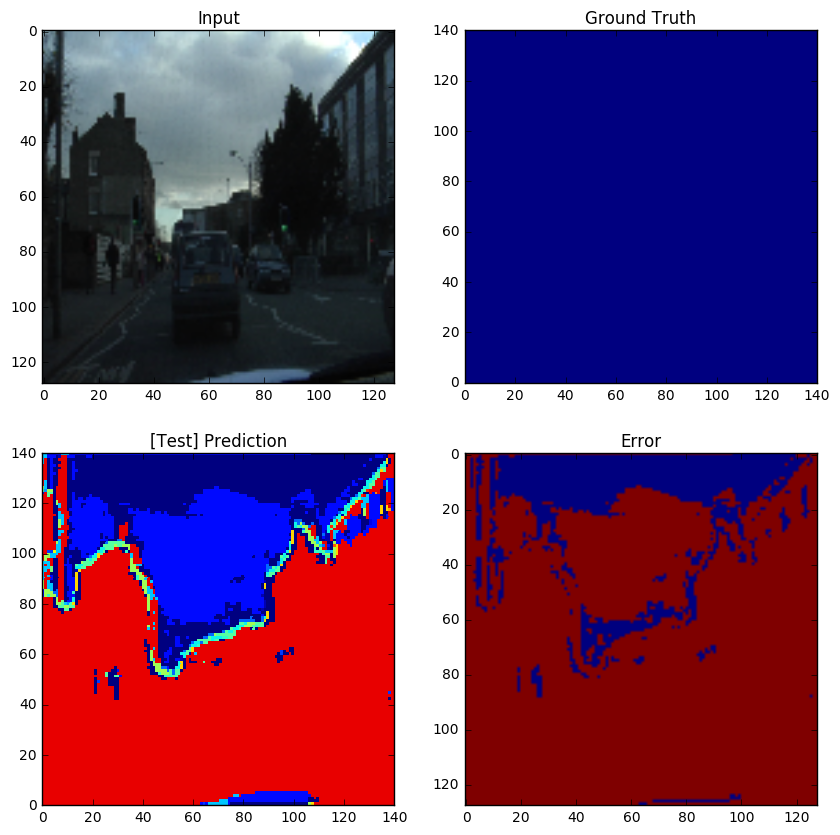

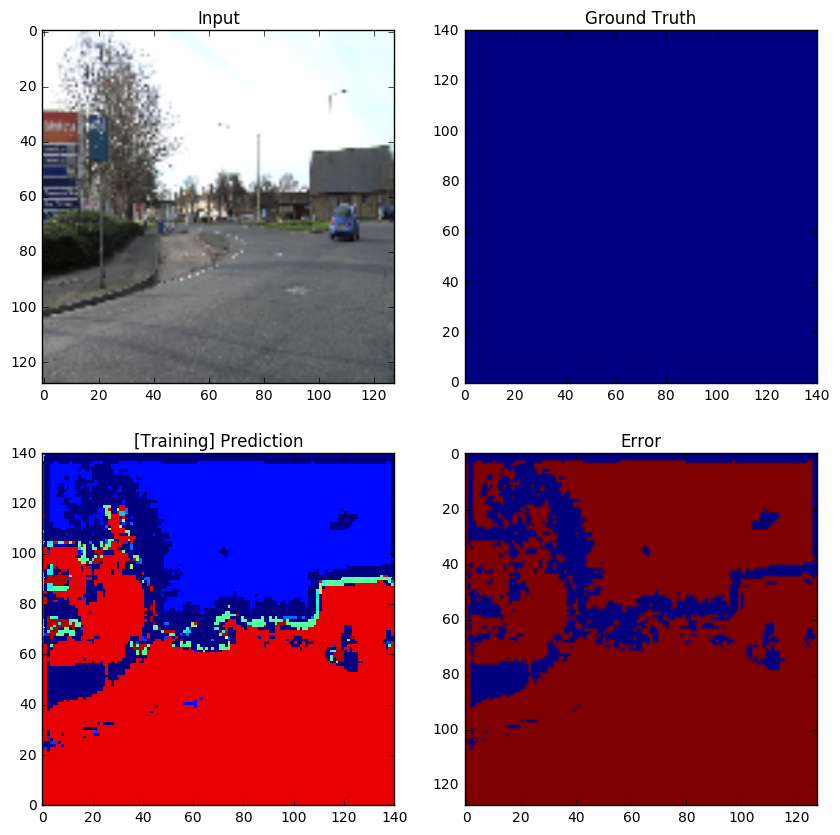

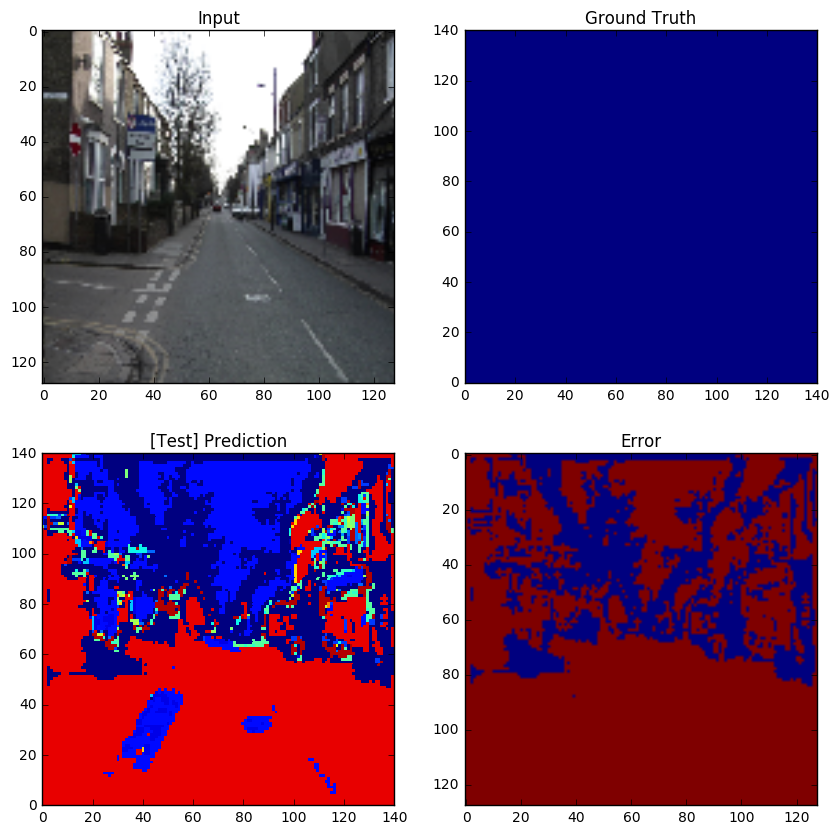

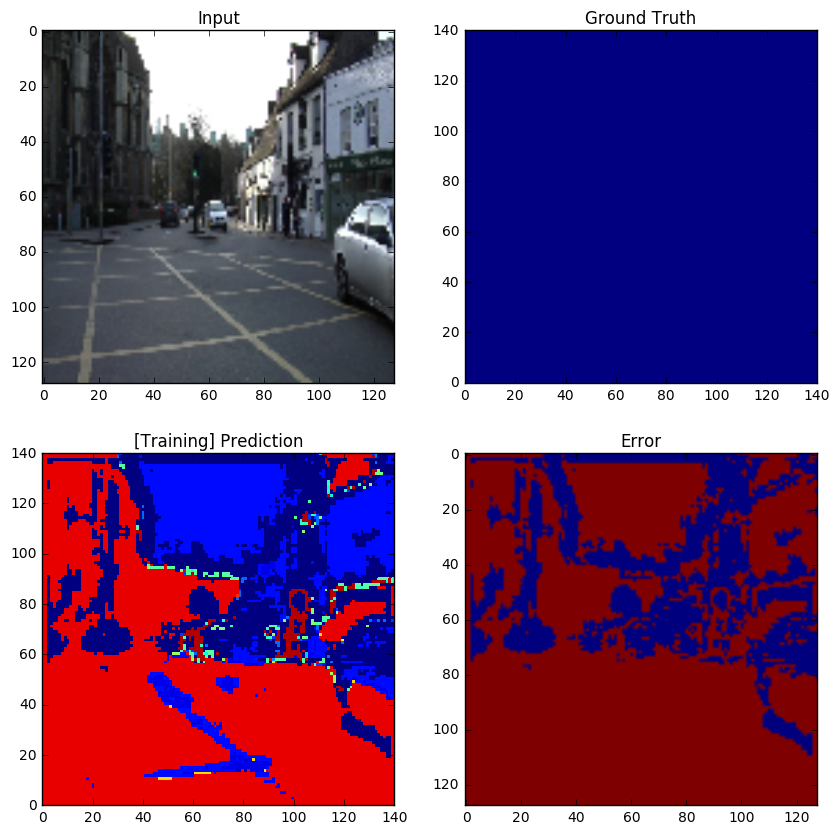

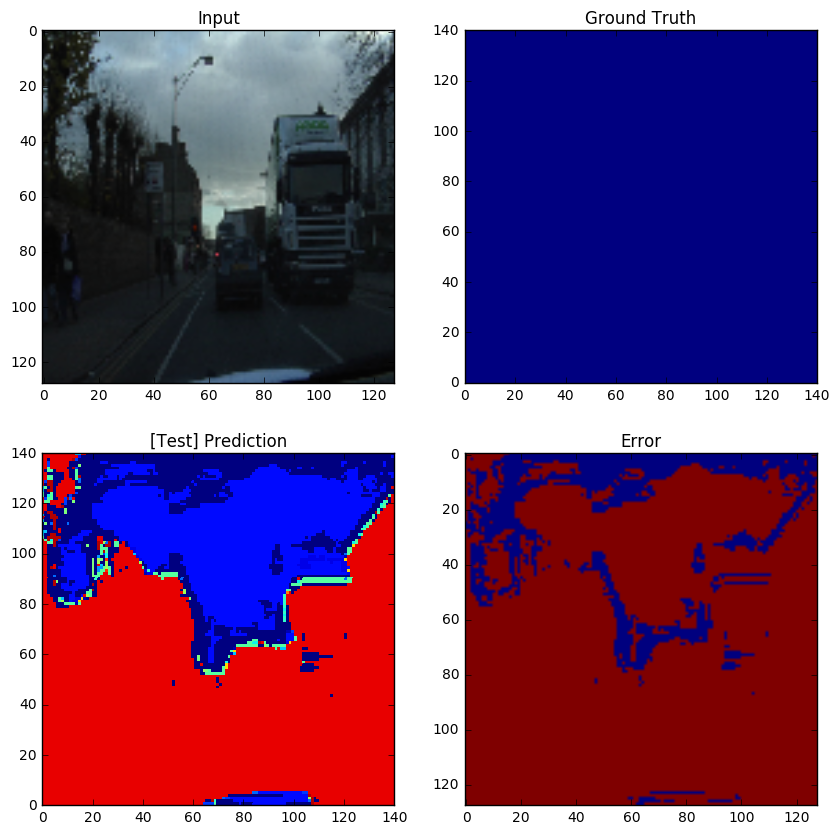

In [11]:
resume_training = True

with tf.Session() as sess:
    #Init all variables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint('nets/semseg_basic')
    print('Checkpoint: ', checkpoint)
    if resume_training == False:
        print('Start from scratch')
    elif checkpoint:
        print('Restoring from checkpoint', checkpoint)
        saver.restore(sess, checkpoint)
    else:
        print('Couldnt find checkpoint to restore from. Starting over')
        
    
    for epoch in range(epochs):
        train_loss = []
        train_accuracy = []
        total_batch = int(n_train/batch_size)+1
        
        for _ in range(total_batch):
            rand_idx = np.random.randint(n_train, size=batch_size)
            batch_data = train_data[rand_idx]
            batch_label = train_label_onehot[rand_idx]
            
            sess.run(optimizer, feed_dict={x: batch_data, y: batch_label, keep_prob: 0.7}) # Optimizer is done here
            
            loss_val, acc = sess.run([loss, accuracy], feed_dict={x: batch_data, y: batch_label, keep_prob: 1.0})
            
            train_loss.append(loss_val)
            train_accuracy.append(acc)
            
        #Avg loss and accuracy
        train_loss = np.mean(train_loss)
        train_accuracy = np.mean(train_accuracy)
        
        #Run test
        test_loss, test_accuracy = sess.run([loss, accuracy], feed_dict={x: test_data, y: test_label_onehot, keep_prob: 1.0})
        print('[%02d/%02d] Train Loss: %.4f, Train Accuracy: %.4f, Test Loss: %.4f, Test Accuracy: %.4f' % (epoch, epochs, train_loss, train_accuracy, test_loss, test_accuracy))
        
        
        #Save snapshot
        if resume_training and epoch % 10 == 0:
            #Save
            saver.save(sess, 'nets/semseg_basic/progress', global_step=epoch)
            
            #Train data
            index = np.random.randint(train_data.shape[0])
            batch_data = train_data[index:index+1]
            batch_label = train_label_onehot[index:index+1]
            pred_max_out = sess.run(pred_max, feed_dict={x: batch_data, y: batch_label, keep_prob:1.0})
            y_max_out = sess.run(y_max, feed_dict={x: batch_data, y: batch_label, keep_prob:1.0})
            
            ref_img = train_data[index, :, :, :].reshape(height, width, 3)
            gt_img = y_max_out[0, :, :].reshape(height, width)
            err_img = gt_img - pred_max_out[0, :, :].reshape(height, width)
            
            #Plot Train data
            xs = np.linspace(0, 140, 128)
            ys = np.linspace(140, 0, 128)
            
            plt.figure(figsize=(10,10))
            
            plt.subplot(2,2,1)
            plt.imshow(ref_img)
            plt.title('Input')
            
            plt.subplot(2,2,2)
            plt.pcolor(xs, ys, gt_img, vmin=0, vmax=n_classes)
            plt.title('Ground Truth')
            
            plt.subplot(2,2,3)
            plt.pcolor(xs, ys, pred_max_out[0,:,:].reshape(height, width), vmin=0, vmax=n_classes)
            plt.title('[Training] Prediction')
            
            plt.subplot(2,2,4)
            plt.imshow(np.abs(err_img) > 0.5)
            plt.title('Error')
            
            
            
            #Test data
            index = np.random.randint(test_data.shape[0])
            batch_data = test_data[index:index+1]
            batch_label = test_label_onehot[index:index+1]
            pred_max_out = sess.run(pred_max, feed_dict={x: batch_data, y: batch_label, keep_prob:1.0})
            y_max_out = sess.run(y_max, feed_dict={x: batch_data, y: batch_label, keep_prob:1.0})
            
            ref_img = test_data[index, :, :, :].reshape(height, width, 3)
            gt_img = y_max_out[0, :, :].reshape(height, width)
            err_img = gt_img - pred_max_out[0, :, :].reshape(height, width)
            
            #Plot Test data
            plt.figure(figsize=(10,10))
            
            plt.subplot(2,2,1)
            plt.imshow(ref_img)
            plt.title('Input')
            
            plt.subplot(2,2,2)
            plt.pcolor(xs, ys, gt_img, vmin=0, vmax=n_classes)
            plt.title('Ground Truth')
            
            plt.subplot(2,2,3)
            plt.pcolor(xs, ys, pred_max_out[0,:,:].reshape(height, width), vmin=0, vmax=n_classes)
            plt.title('[Test] Prediction')
            
            plt.subplot(2,2,4)
            plt.imshow(np.abs(err_img) > 0.5)
            plt.title('Error')
    